In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sqlalchemy import inspect

In [2]:
DRIVER_NAME = 'SQL Server'
SERVER_NAME = 'LAPTOP-3R59J9VQ' 
DATABASE_NAME = 'CompanyX'       

# Connection string for SQLAlchemy
conn_str = f"mssql+pyodbc://{SERVER_NAME}/{DATABASE_NAME}?driver=SQL+Server+Native+Client+11.0"

# Create SQLAlchemy engine
engine = create_engine(conn_str)

In [3]:
query = """
SELECT 
    p.Productname,
    p.ProductID,
    p.Category,
    f.Revenue,
    f.ROI,
    f.NetProfitMargin
FROM 
    Fact f
JOIN 
    DimProduct p ON f.ProductID = p.ProductID
"""

# Load data into a pandas DataFrame
data = pd.read_sql(query, engine)
print("Data loaded successfully.")

Data loaded successfully.


In [4]:
# Preview the data
print("Data Sample:")
print(data.head())

Data Sample:
               Productname  ProductID     Category  Revenue       ROI  \
0      Patch Kit/8 Patches        873  Accessories    1.374  0.335668   
1    Touring-3000 Blue, 58        959        Bikes  445.410 -0.041866   
2    Touring-3000 Blue, 58        959        Bikes  445.410 -0.028718   
3  Touring-3000 Yellow, 44        961        Bikes  445.410 -0.039488   
4  Touring-3000 Yellow, 44        961        Bikes  445.410 -0.043436   

   NetProfitMargin  
0        37.663755  
1        -3.600009  
2        -3.600009  
3        -3.600009  
4        -3.600009  


In [5]:
# Drop rows with missing values
data = data.dropna()
data = data.drop_duplicates()

# Check for NaN values in the dataset
print(data.isnull().sum())

Productname        0
ProductID          0
Category           0
Revenue            0
ROI                0
NetProfitMargin    0
dtype: int64


In [6]:
# Define function to preprocess data for each category
def preprocess_category(data, category_name):
    # Filter data for the given category
    category_data = data[data['Category'] == category_name]
    
    # Select relevant features for clustering
    features = category_data[['Revenue', 'ROI', 'NetProfitMargin']]
    
    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return category_data, features_scaled

In [7]:
def find_optimal_dbscan_params(features, k_neighbors=5, min_samples_range=range(5, 30, 5), eps_search_margin=0.5):
    # """
    # Combines the process of finding optimal eps and min_samples for DBSCAN clustering.

    # Parameters:
    # - features (numpy.ndarray): The standardized features for clustering.
    # - k_neighbors (int): The number of neighbors to use in the k-distance graph.
    # - min_samples_range (range): The range of min_samples values to evaluate.
    # - eps_search_margin (float): The margin around the initial eps to refine the search.

    # Returns:
    # - dict: A dictionary containing optimal eps, min_samples, and the corresponding silhouette score.
    # """
    # Step 1: Find the optimal eps using the k-distance graph
    neighbors = NearestNeighbors(n_neighbors=k_neighbors)
    neighbors_fit = neighbors.fit(features)
    distances, indices = neighbors_fit.kneighbors(features)

    # Sort distances for the k-th nearest neighbor
    distances = np.sort(distances[:, -1], axis=0)

    # Find the elbow point in the k-distance graph
    kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    optimal_knee_point = kneedle.knee
    optimal_eps = distances[optimal_knee_point]

    # Plot the k-distance graph with the elbow point
    plt.figure(figsize=(8, 6))
    plt.plot(distances, label='k-distances')
    plt.axvline(x=optimal_knee_point, color='r', linestyle='--', label=f'Elbow Point: {optimal_eps:.4f}')
    plt.title("K-distance Graph with Elbow Point")
    plt.xlabel("Data Points")
    plt.ylabel("Distance to k-th Nearest Neighbor")
    plt.legend()
    plt.show()

    print(f"Optimal epsilon from K-distance graph (Elbow Method): {optimal_eps:.4f}")

    # Step 2: Refine the search for optimal eps using silhouette scores
    eps_range = np.arange(optimal_eps - eps_search_margin, optimal_eps + eps_search_margin, 0.05)
    silhouette_scores_eps = []
    
    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples_range[0])  # Use the smallest min_samples initially
        labels = dbscan.fit_predict(features)

        if len(set(labels)) > 1:  # Ensure at least 2 clusters
            score = silhouette_score(features, labels)
        else:
            score = -1

        silhouette_scores_eps.append(score)

    optimal_eps_refined = eps_range[np.argmax(silhouette_scores_eps)]

    # Plot silhouette scores for eps
    plt.figure(figsize=(8, 6))
    plt.plot(eps_range, silhouette_scores_eps, 'o--', color='green', label='Silhouette Score')
    plt.axvline(x=optimal_eps_refined, color='r', linestyle='--', label=f'Optimal eps: {optimal_eps_refined:.2f}')
    plt.title('Silhouette Scores for Different eps Values')
    plt.xlabel('eps')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.show()

    print(f"Optimal epsilon from Silhouette Score Method: {optimal_eps_refined:.4f}")

    # Step 3: Find the optimal min_samples using the refined eps
    silhouette_scores_min_samples = []

    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=optimal_eps_refined, min_samples=min_samples)
        labels = dbscan.fit_predict(features)

        if len(set(labels)) > 1:  # Ensure at least 2 clusters
            score = silhouette_score(features, labels)
        else:
            score = -1

        silhouette_scores_min_samples.append(score)

    optimal_min_samples = min_samples_range[np.argmax(silhouette_scores_min_samples)]

    # Plot silhouette scores for min_samples
    plt.figure(figsize=(8, 6))
    plt.plot(min_samples_range, silhouette_scores_min_samples, 'o--', color='blue', label='Silhouette Score')
    plt.axvline(x=optimal_min_samples, color='r', linestyle='--', label=f'Optimal min_samples: {optimal_min_samples}')
    plt.title('Silhouette Scores for Different min_samples Values')
    plt.xlabel('min_samples')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.show()

    print(f"Optimal min_samples from Silhouette Score Method: {optimal_min_samples}")

    # Return the optimal parameters and their silhouette score
    return {
        "optimal_eps": optimal_eps_refined,
        "optimal_min_samples": optimal_min_samples,
        "silhouette_score": max(silhouette_scores_min_samples)
    }


In [8]:
# Function to perform DBSCAN clustering and visualize results
def perform_dbscan_clustering(data, category_name):
    # Preprocess the data
    category_data, features_scaled = preprocess_category(data, category_name)
    
    # Dynamically find the optimal eps and min_samples
    # Define parameters
    k_neighbors = 15
    min_samples_range = range(5, 20, 5)
    eps_search_margin = 0.4
    # Call the function
    optimal_params = find_optimal_dbscan_params(features_scaled, k_neighbors, min_samples_range, eps_search_margin)

    # Extract optimal values
    eps = optimal_params["optimal_eps"]
    min_samples = optimal_params["optimal_min_samples"]
    

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    category_data['Cluster'] = dbscan.fit_predict(features_scaled)
    
    # Visualize clustering results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=category_data, x='Revenue', y='ROI', 
                    hue='Cluster', palette='viridis', s=100, marker='o')
    
    plt.title(f'DBSCAN Clustering Results for {category_name} Category')
    plt.xlabel('Total Revenue')
    plt.ylabel('Return on Investment')
    plt.legend(title='Cluster')
    plt.show()
    
    # Analyze cluster statistics
    cluster_summary = category_data.groupby('Cluster')[['Revenue', 'ROI', 'NetProfitMargin']].mean()
    print(f"Cluster Summary for {category_name} Category:")
    print(cluster_summary)
    
    return category_data




In [9]:
def save_to_sql_server(data, table_name, engine):

    try:
        # Inspect the database schema
        inspector = inspect(engine)
        
        # Check if the table exists
        if not inspector.has_table(table_name):
            print(f"Table '{table_name}' does not exist. Creating the table...")
            # Create the table using the first row of data
            data.head(0).to_sql(table_name, con=engine, if_exists='replace', index=False)
        
        # Check for duplicates by primary key (assumes 'ProductID' as the key)
        existing_ids_query = f"SELECT ProductID FROM {table_name}"
        existing_ids = pd.read_sql(existing_ids_query, con=engine)
        
        # Filter new rows
        new_data = data[~data['ProductID'].isin(existing_ids['ProductID'])]
        
        if not new_data.empty:
            # Append new data
            new_data.to_sql(table_name, con=engine, if_exists='append', index=False)
            print(f"Data successfully saved to table '{table_name}'.")
        else:
            print("No new data to add. Skipping update.")
    except Exception as e:
        print(f"Error saving data to SQL Server: {e}")

In [10]:
# Example: Preprocess the 'Bike' category
bikes_data, bikes_features = preprocess_category(data, 'Bikes')
clothing_data, clothing_features = preprocess_category(data, 'Clothing')
components_data, components_features = preprocess_category(data, 'Components')
accessories_data, accessories_features = preprocess_category(data, 'Accessories')


--- Clustering for Bikes Category ---


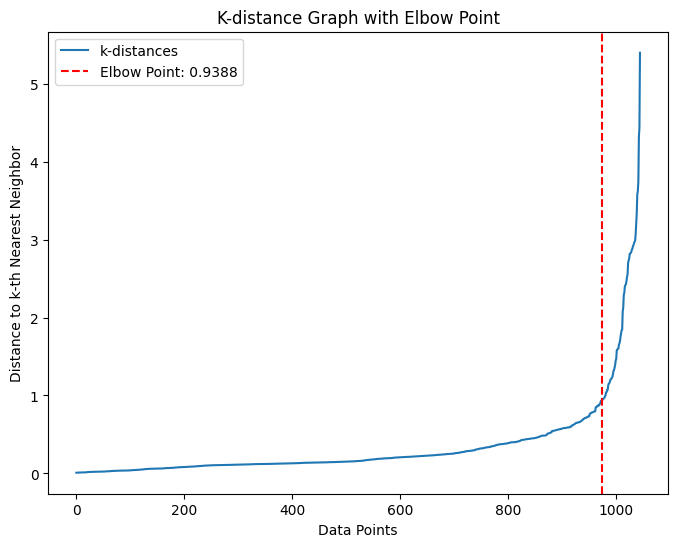

Optimal epsilon from K-distance graph (Elbow Method): 0.9388


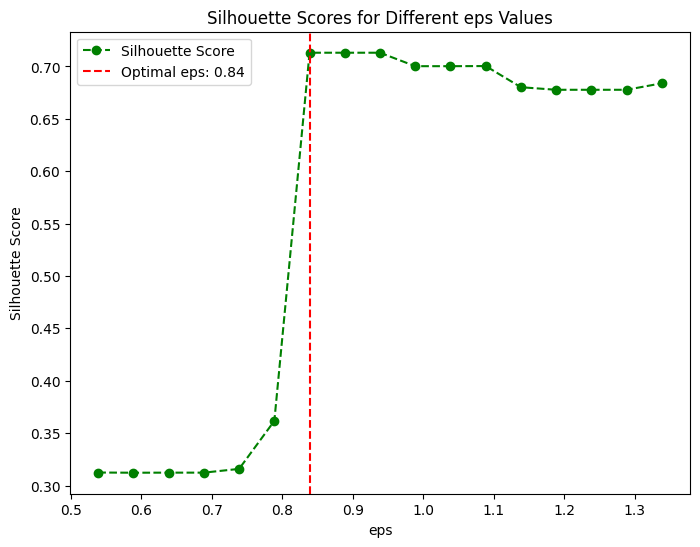

Optimal epsilon from Silhouette Score Method: 0.8388


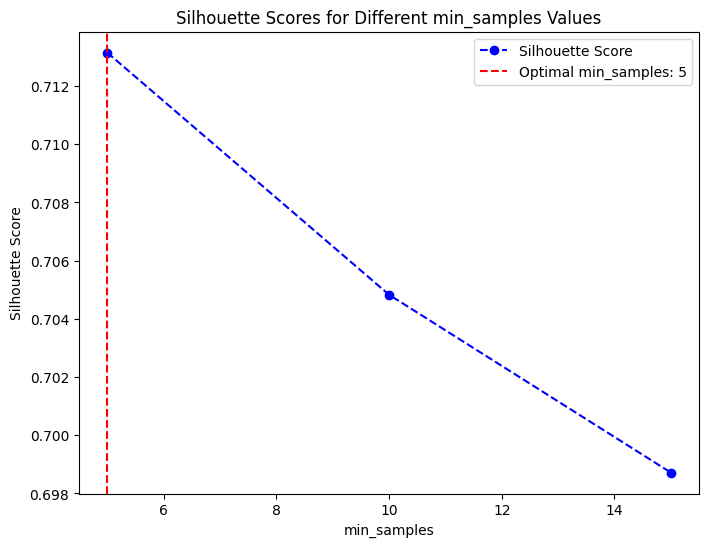

Optimal min_samples from Silhouette Score Method: 5


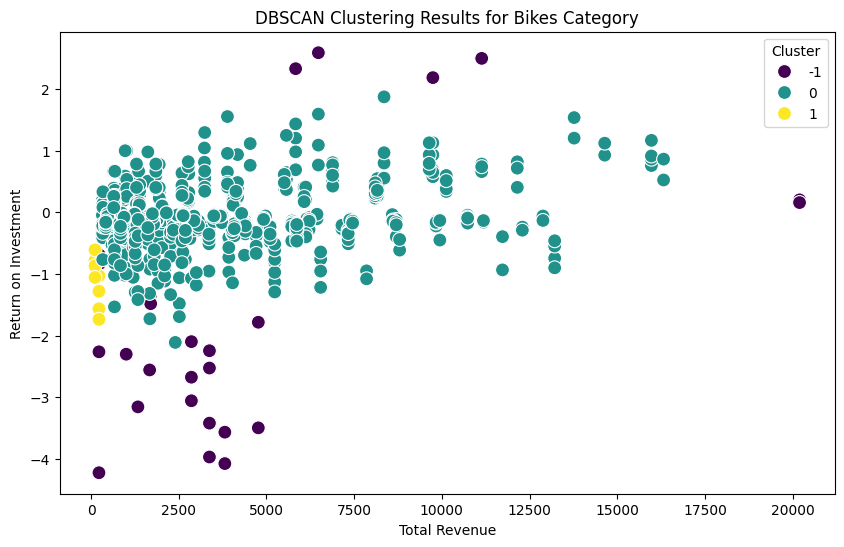

Cluster Summary for Bikes Category:
             Revenue       ROI  NetProfitMargin
Cluster                                        
-1       4387.482036 -1.534734       -72.383164
 0       3053.987233 -0.070247        -3.928267
 1        169.497000 -1.115365      -172.764031


In [11]:
# Apply DBSCAN clustering for Bikes (eps and min_samples are calculated dynamically)
print(f"\n--- Clustering for Bikes Category ---")
bikes_clustered_data = perform_dbscan_clustering(bikes_data, 'Bikes')


--- Clustering for Clothing Category ---


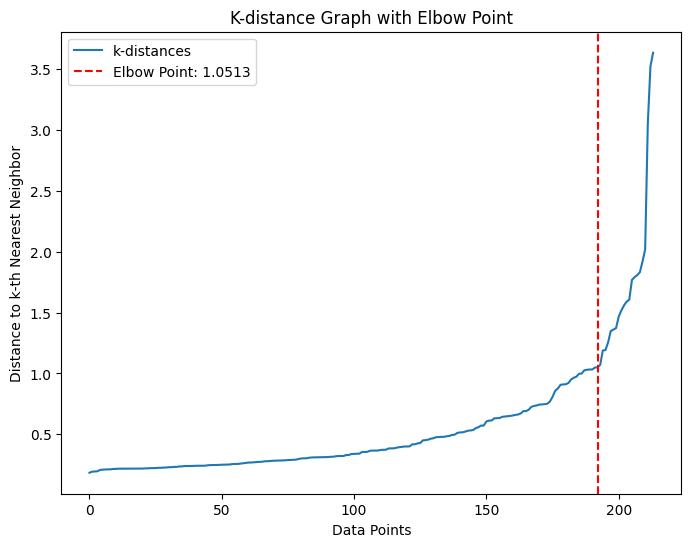

Optimal epsilon from K-distance graph (Elbow Method): 1.0513


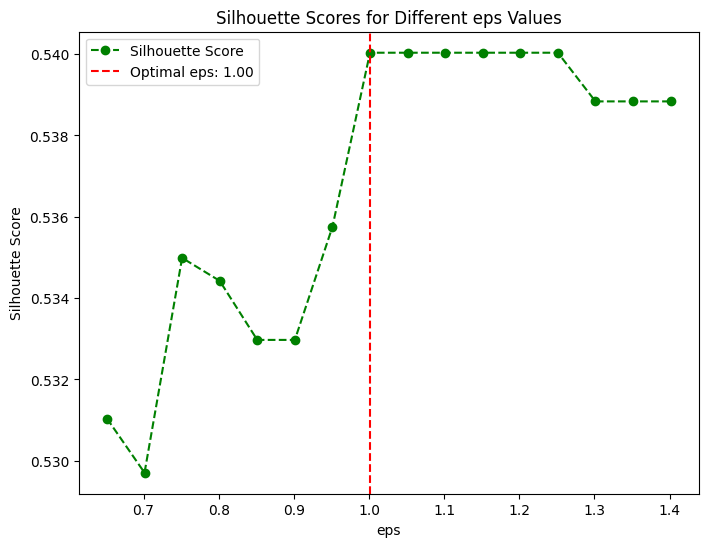

Optimal epsilon from Silhouette Score Method: 1.0013


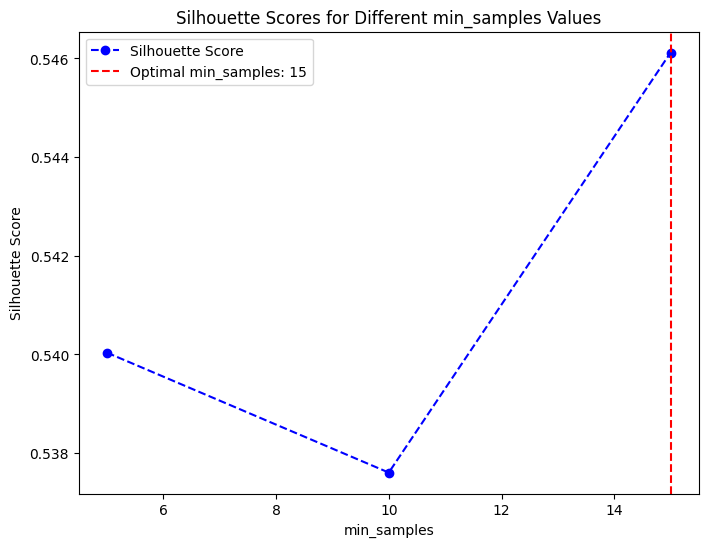

Optimal min_samples from Silhouette Score Method: 15


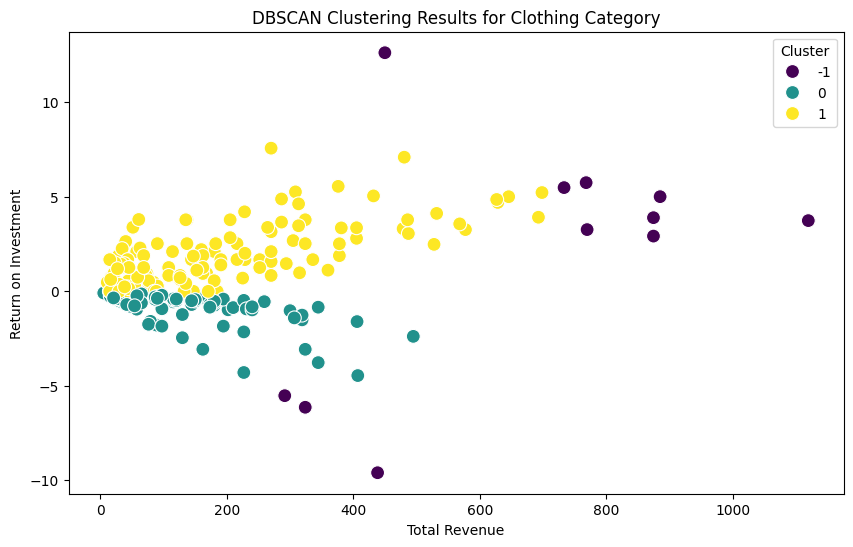

Cluster Summary for Clothing Category:
            Revenue       ROI  NetProfitMargin
Cluster                                       
-1       684.586664  1.951427        13.220373
 0       144.036984 -0.930568       -31.448072
 1       193.185730  1.919661        33.888988


In [12]:
# Apply DBSCAN clustering for Clothing (eps and min_samples are calculated dynamically)
print(f"\n--- Clustering for Clothing Category ---")
clothing_clustered_data = perform_dbscan_clustering(clothing_data, 'Clothing')


--- Clustering for Components Category ---


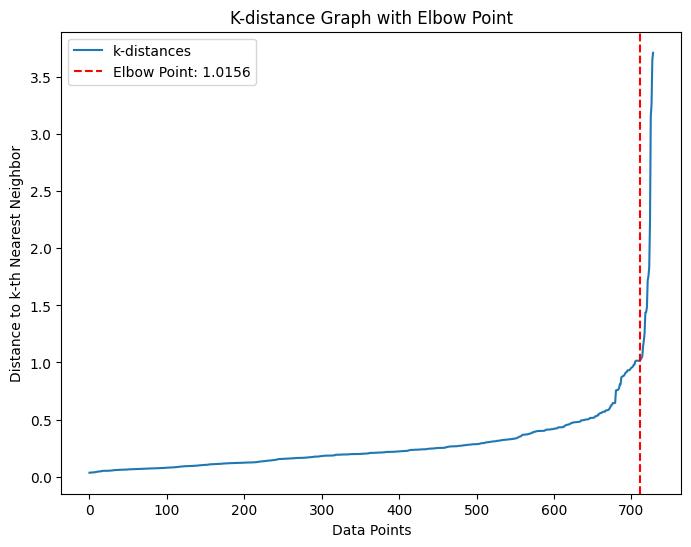

Optimal epsilon from K-distance graph (Elbow Method): 1.0156


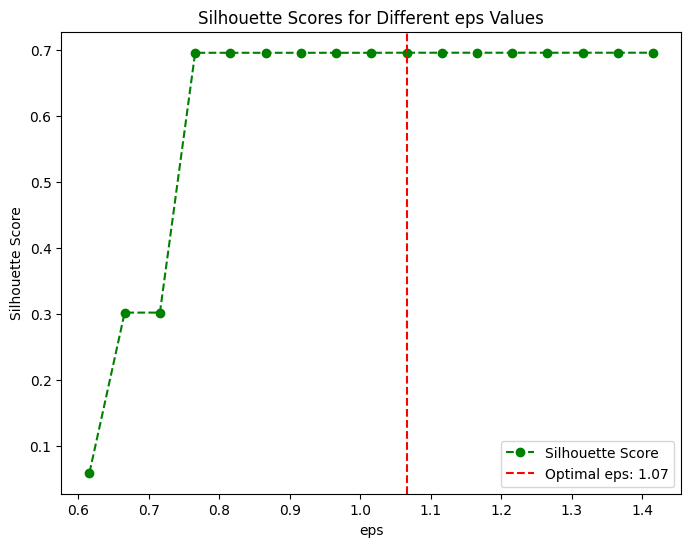

Optimal epsilon from Silhouette Score Method: 1.0656


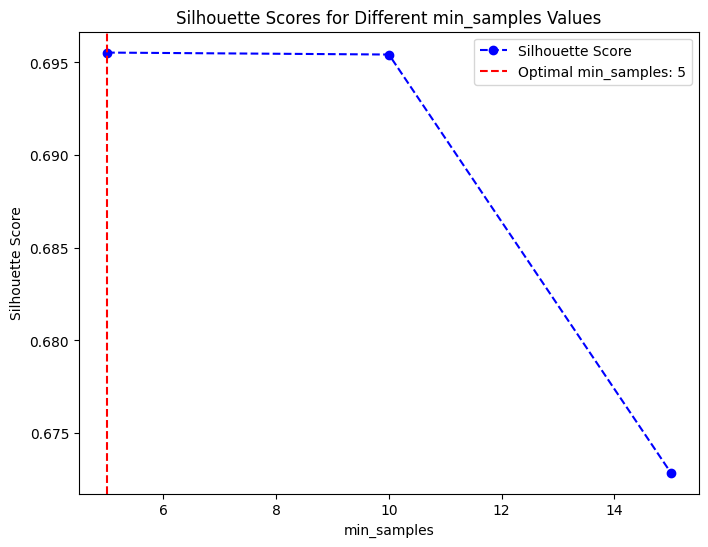

Optimal min_samples from Silhouette Score Method: 5


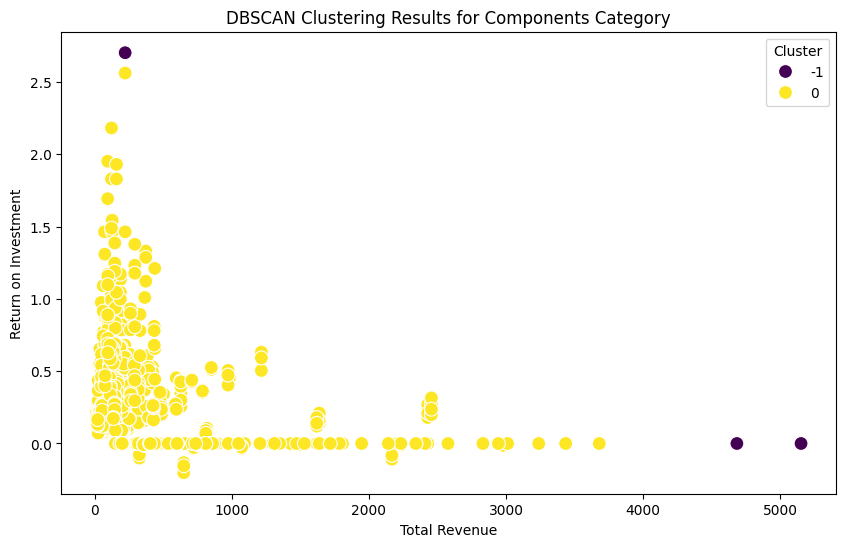

Cluster Summary for Components Category:
             Revenue       ROI  NetProfitMargin
Cluster                                        
-1       3353.005233  0.900895         4.786625
 0        493.207910  0.285485        16.714759


In [13]:
# Apply DBSCAN clustering for Components (eps and min_samples are calculated dynamically)
print(f"\n--- Clustering for Components Category ---")
components_clustered_data = perform_dbscan_clustering(components_data, 'Components')


--- Clustering for Accessories Category ---


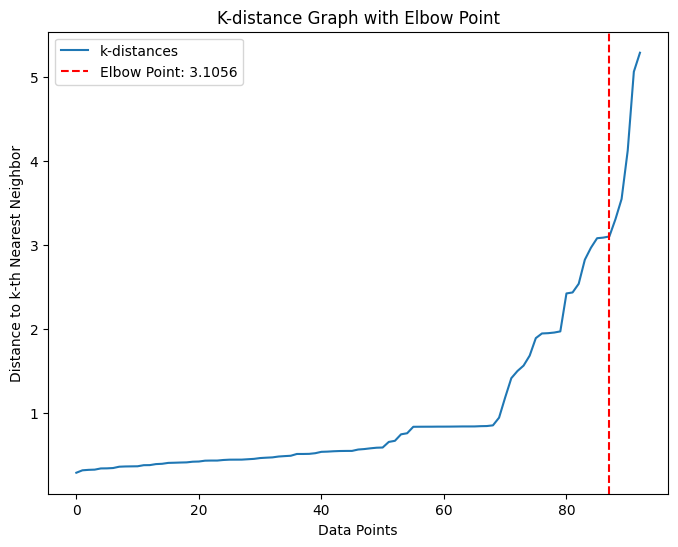

Optimal epsilon from K-distance graph (Elbow Method): 3.1056


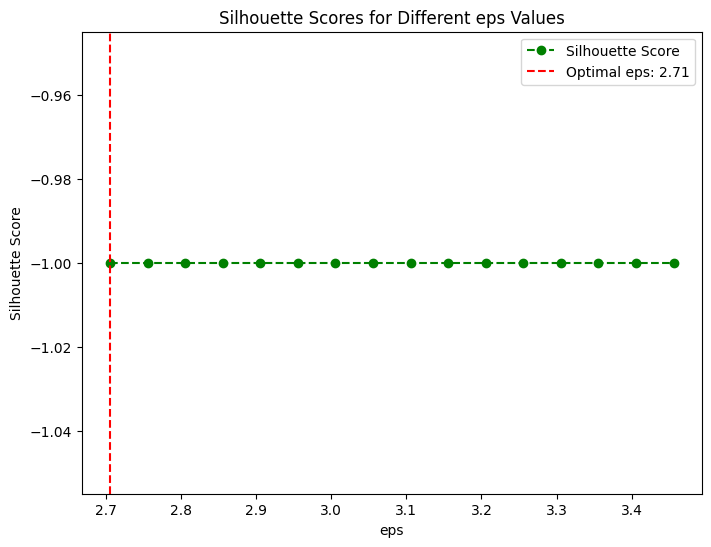

Optimal epsilon from Silhouette Score Method: 2.7056


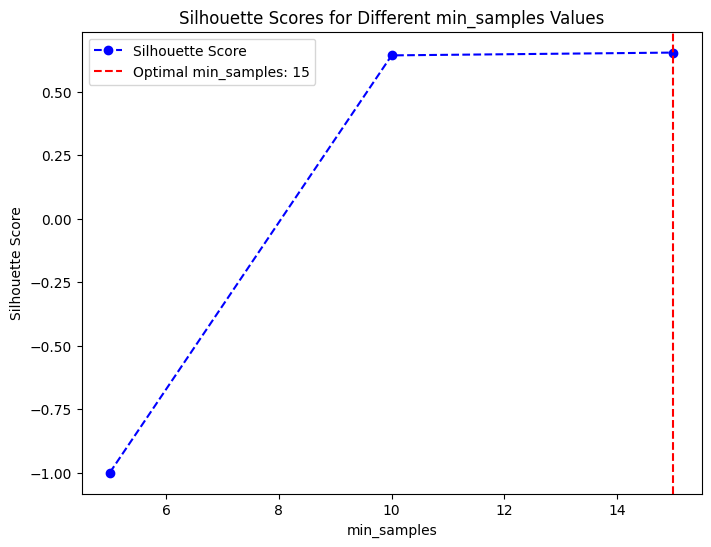

Optimal min_samples from Silhouette Score Method: 15


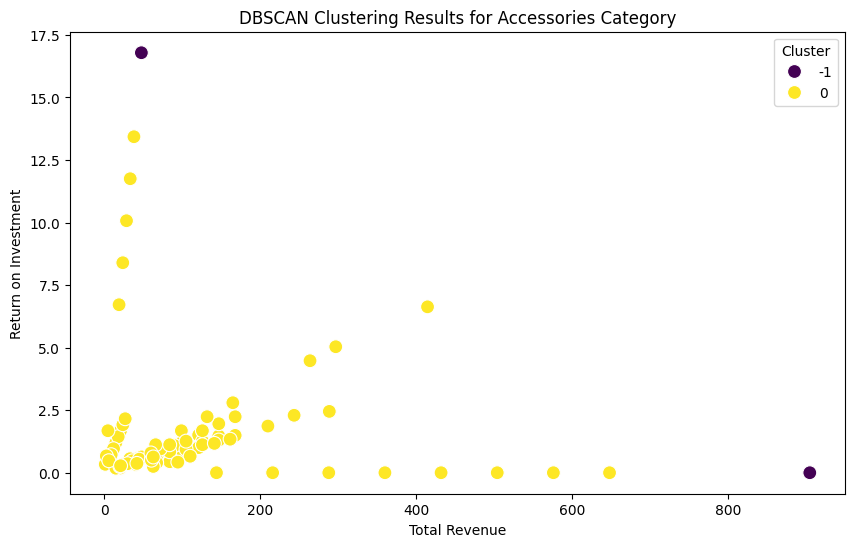

Cluster Summary for Accessories Category:
            Revenue       ROI  NetProfitMargin
Cluster                                       
-1       476.250000  8.392751        36.591954
 0       111.345223  1.539933        34.924959


In [14]:
# Apply DBSCAN clustering for Accessories (eps and min_samples are calculated dynamically)
print(f"\n--- Clustering for Accessories Category ---")
accessories_clustered_data = perform_dbscan_clustering(accessories_data, 'Accessories')

In [15]:
#Save to SQL Server
save_to_sql_server(bikes_clustered_data, 'DBSCAN_Bikes_Clusters', engine)

No new data to add. Skipping update.


In [16]:
save_to_sql_server(clothing_clustered_data, 'DBSCAN_Clothing_Clusters', engine)

No new data to add. Skipping update.


In [17]:
save_to_sql_server(components_clustered_data, 'DBSCAN_Components_Clusters', engine)

No new data to add. Skipping update.


In [18]:
save_to_sql_server(accessories_clustered_data, 'DBSCAN_Accessories_Clusters', engine)

No new data to add. Skipping update.
